In [1]:
import sys
import time

# Maths things
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Algorithm
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.manifold import MDS

In [2]:
data = np.load('regression_data.npy')
target = np.loadtxt('target_values.txt')

In [3]:
error = mean_absolute_error

In [4]:
X_ltrain, X_test, Y_ltrain, Y_test = train_test_split(data, target, test_size = 100, random_state = 7)

In [5]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_ltrain, Y_ltrain, test_size = 100, random_state = 17)

In [6]:
X_train.shape

(554, 27827)

# Feature Selection

## MDS

### Optimization of the number of PC

In [9]:
%%time
numbers_pc = np.arange(1,54)
losses_mds_n_pc = np.zeros((len(numbers_pc)))
for i,n_pc in enumerate(numbers_pc):
    mds = MDS(n_components=n_pc)
    T_train = mds.fit_transform(X_train)
    T_valid= mds.fit_transform(X_valid)
    lr = LinearRegression()
    lr.fit(T_train, Y_train)
    Y_pred = lr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_mds_n_pc[i] = loss
    print(n_pc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
CPU times: user 23min 16s, sys: 52.4 s, total: 24min 8s
Wall time: 14min 58s


In [10]:
losses_mds_n_pc

array([1.70622212, 1.63574975, 1.83713252, 1.78130415, 2.34186572,
       2.80867289, 2.08447939, 2.488314  , 2.59003319, 2.8961444 ,
       2.80845419, 2.60008304, 2.11498354, 2.13471303, 2.17914216,
       2.10599657, 2.39709767, 3.57549061, 2.53991985, 1.95249647,
       2.42672712, 2.2830498 , 2.66134445, 2.17718719, 2.50324347,
       2.39670339, 2.93903986, 2.8210144 , 1.89142788, 1.93976293,
       2.26545401, 3.79324889, 2.14526153, 2.47725094, 2.81505089,
       1.8741061 , 3.16464546, 2.29932445, 3.19346322, 3.59330852,
       2.22279314, 2.58478332, 2.37518256, 1.98995646, 2.21247305,
       2.95399067, 2.78657894, 2.15717394, 2.29103358, 2.87136538,
       2.19156315, 1.6782313 , 1.80860726])

In [11]:
optimal_index_n_pc_mds = np.unravel_index(losses_mds_n_pc.argmin(), losses_mds_n_pc.shape)
optimal_n_pc_mds = numbers_pc[optimal_index_n_pc_mds]
print("Optimal number of n_pc for MDS using LR is {} ".format(optimal_n_pc_mds))

Optimal number of n_pc for MDS using LR is 2 


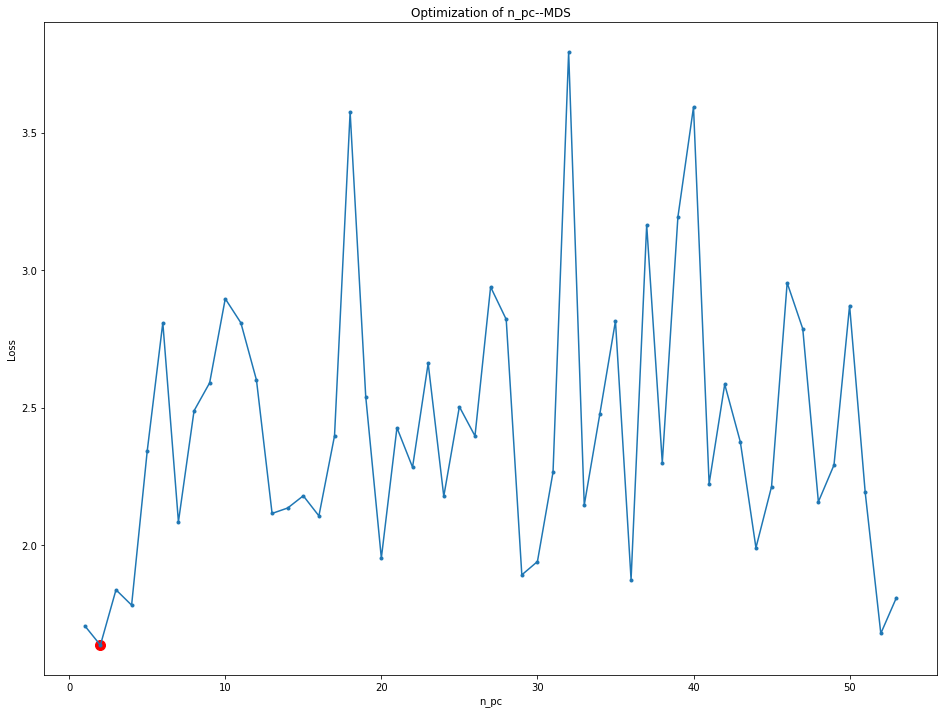

In [12]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_pc,losses_mds_n_pc,'.-')
plt.scatter(optimal_n_pc_mds, losses_mds_n_pc[optimal_index_n_pc_mds], s = 100,marker='o', color='r')
plt.xlabel('n_pc')
#plt.yscale('log')
plt.ylabel('Loss')
#plt.legend()
plt.title('Optimization of n_pc--'+'MDS')
plt.show()

# Retrain and Datat Processing

In [14]:
optimal_n_pc_pls = 2

In [17]:
best_mds = MDS(n_components=2)
best_mds.fit(X_ltrain)
T_ltrain = best_mds.fit_transform(X_ltrain)
T_train  = best_mds.fit_transform(X_train)
T_valid  = best_mds.fit_transform(X_valid)
T_test   = best_mds.fit_transform(X_test)

# Try different regression models

## Linear Regression

### No need for optimization

### Learning Curve

In [18]:
lr = LinearRegression()
numbers_train = np.arange(54,655,50)
losses_lr = np.zeros((len(numbers_train)))

In [19]:
%%time
for i,n in enumerate(numbers_train):
    Tt_train = T_ltrain[:n]
    Yt_train = Y_ltrain[:n]
    lr.fit(Tt_train,Yt_train)
    Y_pred = lr.predict(T_test)
    loss = error(Y_test, Y_pred)
    losses_lr[i] = loss
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 55.9 ms, sys: 13.2 ms, total: 69.1 ms
Wall time: 165 ms


In [20]:
optimal_index_loss_lr = np.unravel_index(losses_lr.argmin(), losses_lr.shape)
optimal_n_train_lr = numbers_train[optimal_index_loss_lr]
min_loss_lr = losses_lr[optimal_index_loss_lr]
print("Minimum loss of LR with PLS is {} when number of train is {}  ".format(min_loss_lr,optimal_n_train_lr))

Minimum loss of LR with PLS is 1.5825946871769088 when number of train is 404  


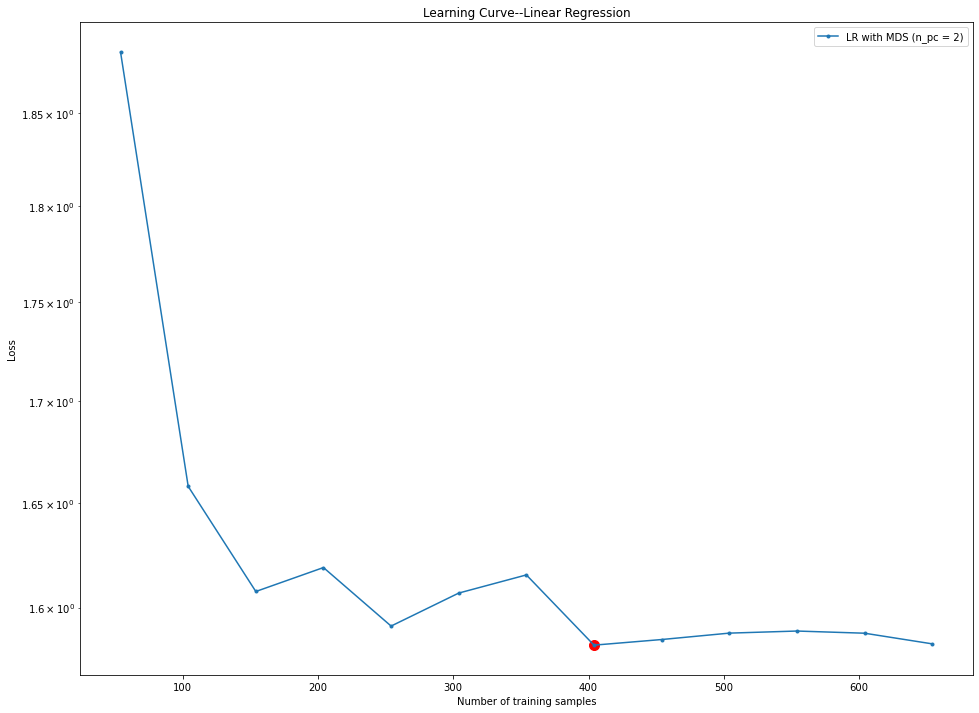

In [24]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_lr,'.-', label='LR with MDS (n_pc = {})'.format(optimal_n_pc_mds))
plt.scatter(optimal_n_train_lr, min_loss_lr, s = 100,marker='o', color='r')
plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve--'+'Linear Regression')
plt.show()

## Ridge Regression

### Optimization

#### Optimization of alpha

In [26]:
%%time
alphas =  np.logspace(-10, 4, 29)
losses_rr_alpha = np.zeros((len(alphas)))
for i,alpha in enumerate(alphas):
    rr = Ridge(alpha = alpha)
    rr.fit(T_train, Y_train)
    Y_pred = rr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_rr_alpha[i] = loss
    print(alpha)

1e-10
3.1622776601683795e-10
1e-09
3.1622776601683795e-09
1e-08
3.162277660168379e-08
1e-07
3.162277660168379e-07
1e-06
3.162277660168379e-06
1e-05
3.1622776601683795e-05
0.0001
0.00031622776601683794
0.001
0.0031622776601683794
0.01
0.03162277660168379
0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
31.622776601683793
100.0
316.22776601683796
1000.0
3162.2776601683795
10000.0
CPU times: user 81 ms, sys: 14.8 ms, total: 95.8 ms
Wall time: 179 ms


In [27]:
optimal_index_alpha_rr = np.unravel_index(losses_rr_alpha.argmin(), losses_rr_alpha.shape)
optimal_alpha_rr = alphas[optimal_index_alpha_rr]
print("Optimal alpha for RR with MDS is {} ".format(optimal_alpha_rr))

Optimal alpha for RR with MDS is 10000.0 


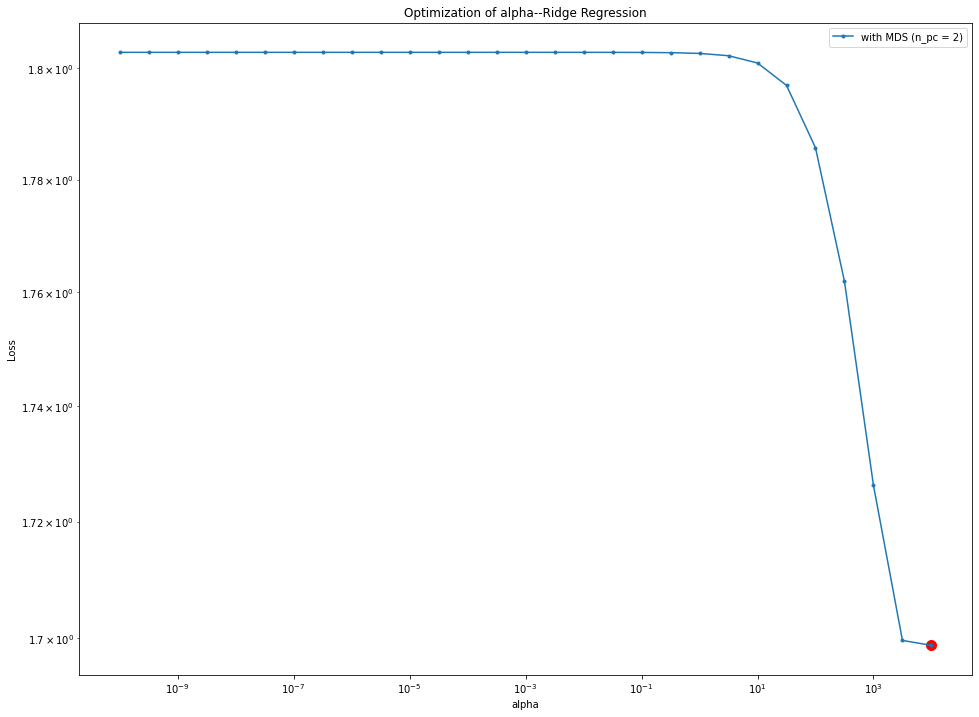

In [28]:
plt.figure(figsize=(16, 12))
plt.plot(alphas,losses_rr_alpha,'.-', label='with MDS (n_pc = {})'.format(optimal_n_pc_mds))
plt.scatter(optimal_alpha_rr, losses_rr_alpha[optimal_index_alpha_rr], s = 100,marker='o', color='r')
plt.xlabel('alpha')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Optimization of alpha--'+'Ridge Regression')
plt.show()

### Learning Curve

In [29]:
best_rr = Ridge(alpha = optimal_alpha_rr)
numbers_train = np.arange(54,655,50)
losses_rr = np.zeros((len(numbers_train)))

In [30]:
%%time
for i,n in enumerate(numbers_train):
    Tt_train = T_ltrain[:n]
    Yt_train = Y_ltrain[:n]
    best_rr.fit(Tt_train,Yt_train)
    Y_pred = best_rr.predict(T_test)
    loss = error(Y_test, Y_pred)
    losses_rr[i] = loss
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 39.1 ms, sys: 6.9 ms, total: 46 ms
Wall time: 32.1 ms


In [31]:
losses_rr

array([1.74898954, 1.75856236, 1.74550647, 1.74436677, 1.74173074,
       1.73798374, 1.73376538, 1.73630701, 1.73464804, 1.73161361,
       1.73338567, 1.73151541, 1.72897447])

In [32]:
optimal_index_loss_rr = np.unravel_index(losses_rr.argmin(), losses_rr.shape)
optimal_n_train_rr = numbers_train[optimal_index_loss_rr]
min_loss_rr = losses_rr[optimal_index_loss_rr]
print("Minimum loss of RR with MDS is {} when number of train is {}  ".format(min_loss_rr,optimal_n_train_rr))

Minimum loss of RR with MDS is 1.7289744675697347 when number of train is 654  


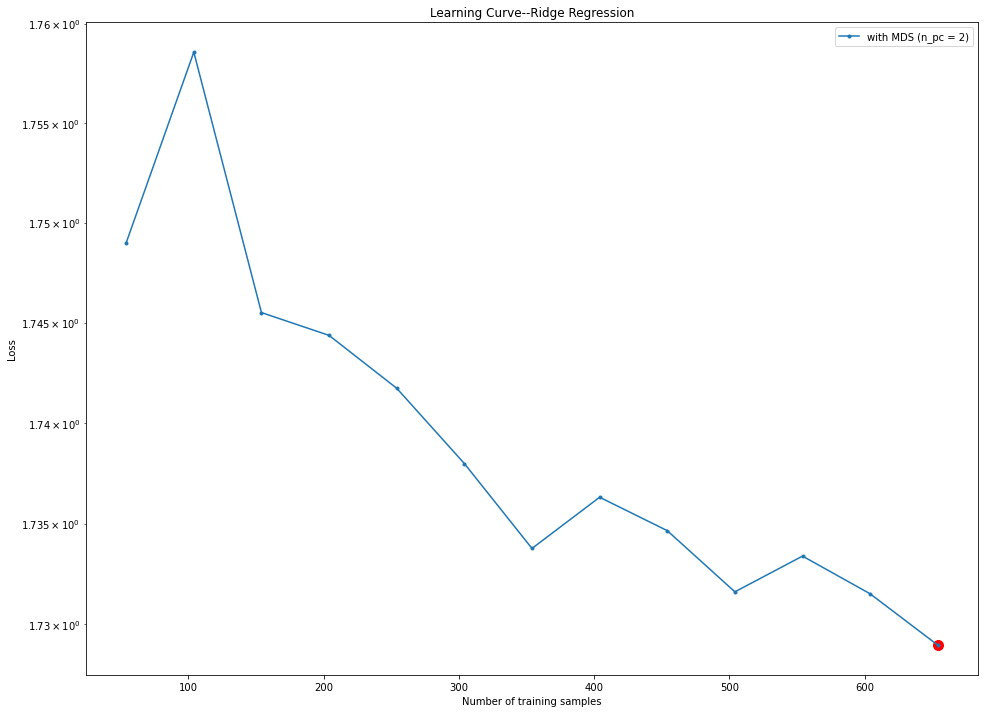

In [33]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_rr,'.-', label='with MDS (n_pc = {})'.format(optimal_n_pc_mds))
plt.scatter(optimal_n_train_rr, min_loss_rr, s = 100,marker='o', color='r')
plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve--'+'Ridge Regression')
plt.show()

## Kernel Ridge Regression

### Optimization

#### Optimization of gamma

In [34]:
%%time
gammas =  np.logspace(-10, 1, 23)
losses_krr_gamma = np.zeros((len(gammas)))
kernel_params = {"kernel": "rbf", "gamma": 1.0}
for i,gamma in enumerate(gammas):
    kernel_params["gamma"] = gamma
    krr = KernelRidge(alpha = 1e-6, **kernel_params)
    krr.fit(T_train, Y_train)
    Y_pred = krr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_krr_gamma[i] = loss
    print(gamma)

1e-10
3.1622776601683795e-10
1e-09
3.1622776601683795e-09
1e-08
3.162277660168379e-08
1e-07
3.162277660168379e-07
1e-06
3.162277660168379e-06
1e-05
3.1622776601683795e-05
0.0001
0.00031622776601683794
0.001
0.0031622776601683794
0.01
0.03162277660168379
0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
CPU times: user 714 ms, sys: 44.5 ms, total: 758 ms
Wall time: 555 ms


In [36]:
optimal_index_gamma_krr = np.unravel_index(losses_krr_gamma.argmin(), losses_krr_gamma.shape)
optimal_gamma_krr = gammas[optimal_index_gamma_krr]
print("Optimal gamma for KRR with MDS is {} ".format(optimal_gamma_krr))

Optimal gamma for KRR with MDS is 1e-10 


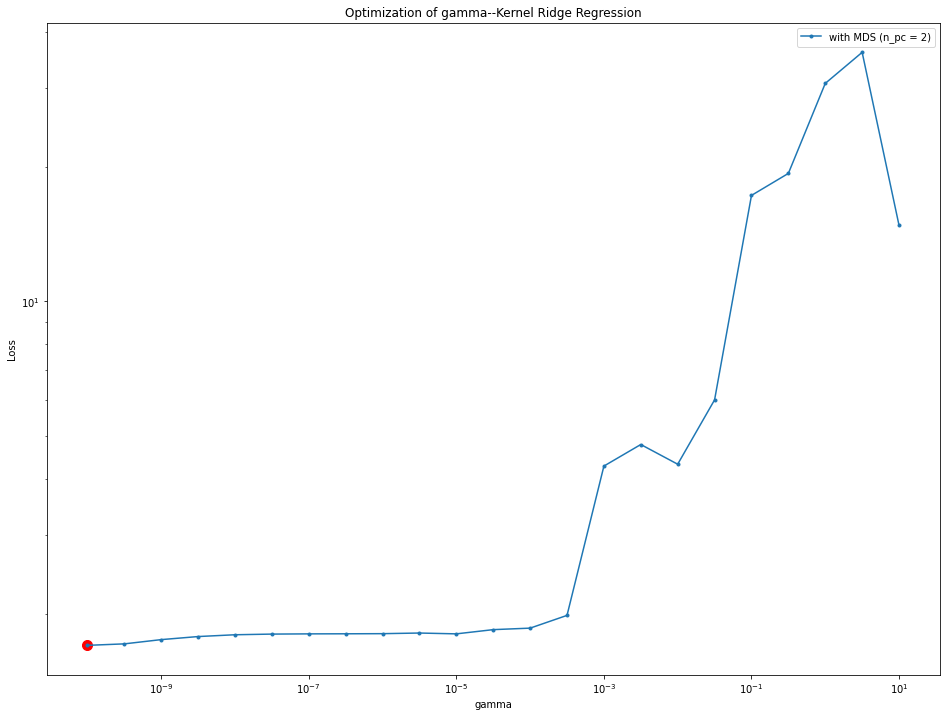

In [37]:
plt.figure(figsize=(16, 12))
plt.plot(gammas,losses_krr_gamma,'.-', label='with MDS (n_pc = {})'.format(optimal_n_pc_mds))
plt.scatter(optimal_gamma_krr, losses_krr_gamma[optimal_index_gamma_krr], s = 100,marker='o', color='r')
plt.xlabel('gamma')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Optimization of gamma--'+'Kernel Ridge Regression')
plt.show()

#### Optimization of alpha

In [38]:
%%time
alphas =  np.logspace(-10, 1, 23)
losses_krr_alpha = np.zeros((len(alphas)))
kernel_params = {"kernel": "rbf", "gamma": optimal_gamma_krr}
for i,alpha in enumerate(alphas):
    krr = KernelRidge(alpha = alpha, **kernel_params)
    krr.fit(T_train, Y_train)
    Y_pred = krr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_krr_alpha[i] = loss
    print(alpha)

1e-10
3.1622776601683795e-10
1e-09
3.1622776601683795e-09
1e-08
3.162277660168379e-08
1e-07
3.162277660168379e-07
1e-06
3.162277660168379e-06
1e-05
3.1622776601683795e-05
0.0001
0.00031622776601683794
0.001
0.0031622776601683794
0.01
0.03162277660168379
0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
CPU times: user 730 ms, sys: 43.6 ms, total: 774 ms
Wall time: 573 ms


In [39]:
optimal_index_alpha_krr = np.unravel_index(losses_krr_alpha.argmin(), losses_krr_alpha.shape)
optimal_alpha_krr = alphas[optimal_index_alpha_krr]
print("Optimal alpha for KRR with MDS is {} ".format(optimal_alpha_krr))

Optimal alpha for KRR with PLS is 10.0 


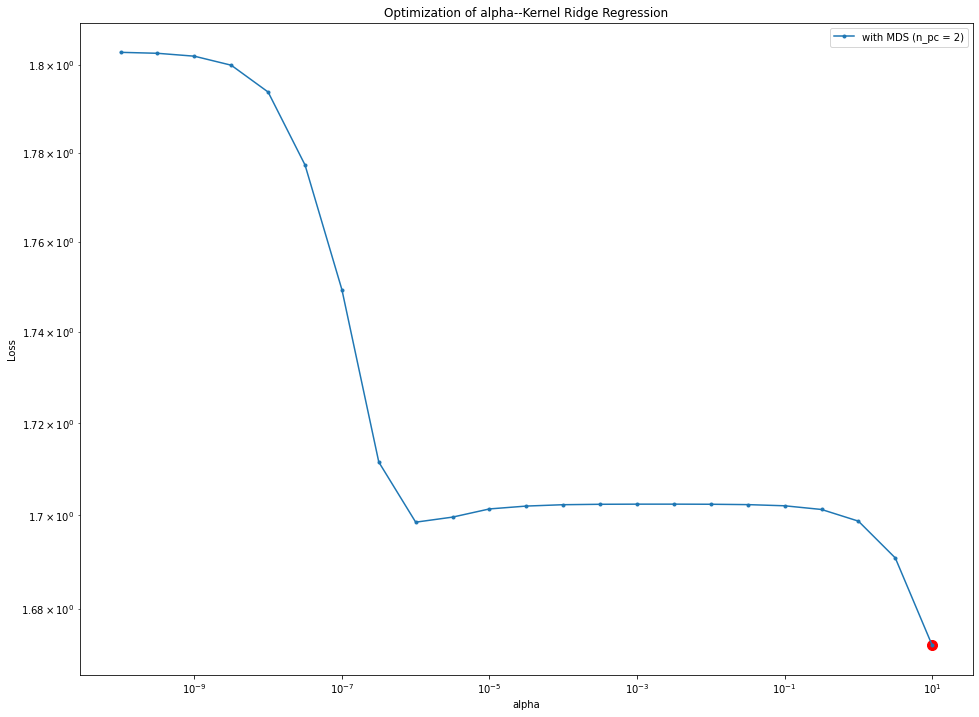

In [40]:
plt.figure(figsize=(16, 12))
plt.plot(alphas,losses_krr_alpha,'.-', label='with MDS (n_pc = {})'.format(optimal_n_pc_mds))
plt.scatter(optimal_alpha_krr, losses_krr_alpha[optimal_index_alpha_krr], s = 100,marker='o', color='r')
plt.xlabel('alpha')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Optimization of alpha--'+'Kernel Ridge Regression')
plt.show()

### Learning Curve

In [41]:
best_krr = KernelRidge(alpha = optimal_alpha_krr, **kernel_params)
numbers_train = np.arange(54,655,50)
losses_krr = np.zeros((len(numbers_train)))

In [42]:
%%time
for i,n in enumerate(numbers_train):
    Tt_train = T_ltrain[:n]
    Yt_train = Y_ltrain[:n]
    best_krr.fit(Tt_train,Yt_train)
    Y_pred = best_krr.predict(T_test)
    loss = error(Y_test, Y_pred)
    losses_krr[i] = loss
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 265 ms, sys: 61.1 ms, total: 326 ms
Wall time: 347 ms


In [43]:
losses_krr

array([1.97283547, 1.75077752, 1.73688913, 1.73633425, 1.73800605,
       1.73895277, 1.73907886, 1.74073695, 1.7409992 , 1.74095073,
       1.74214242, 1.74240692, 1.74271829])

In [45]:
optimal_index_loss_krr = np.unravel_index(losses_krr.argmin(), losses_krr.shape)
optimal_n_train_krr = numbers_train[optimal_index_loss_krr]
min_loss_krr = losses_krr[optimal_index_loss_krr]
print("Minimum loss of KRR with MDS is {} when number of train is {}  ".format(min_loss_krr,optimal_n_train_krr))

Minimum loss of KRR with MDS is 1.7363342540683204 when number of train is 204  


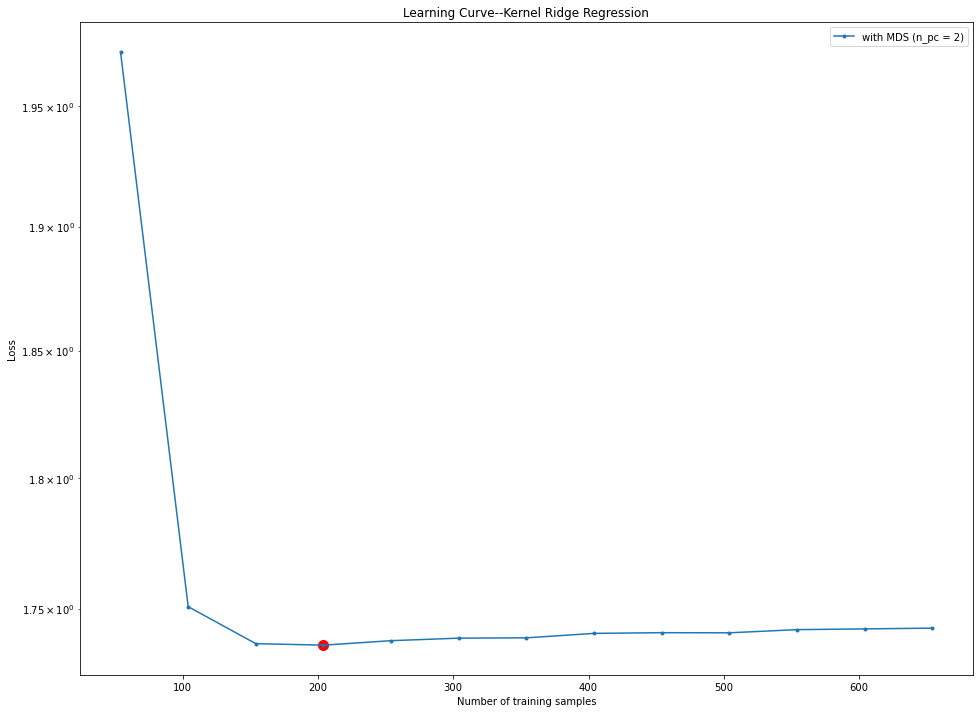

In [46]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_krr,'.-', label='with MDS (n_pc = {})'.format(optimal_n_pc_mds))
plt.scatter(optimal_n_train_krr, min_loss_krr, s = 100,marker='o', color='r')
plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve--'+'Kernel Ridge Regression')
plt.show()

### Summary

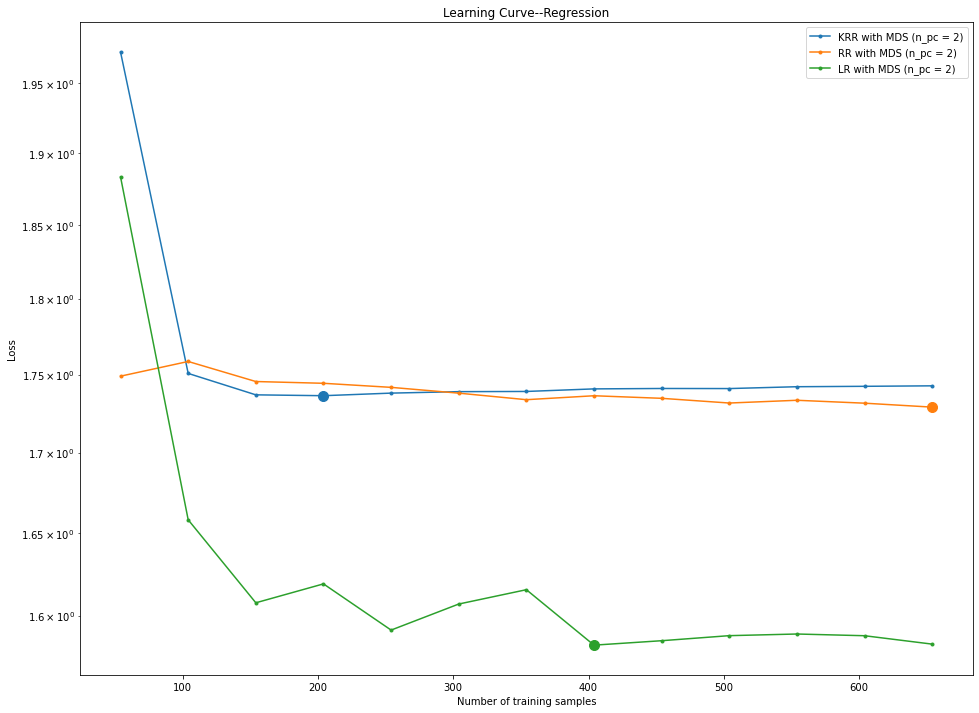

In [48]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_krr,'.-', label='KRR with MDS (n_pc = {})'.format(optimal_n_pc_mds))
plt.scatter(optimal_n_train_krr, min_loss_krr, s = 100,marker='o')
plt.plot(numbers_train,losses_rr,'.-', label='RR with MDS (n_pc = {})'.format(optimal_n_pc_mds))
plt.scatter(optimal_n_train_rr, min_loss_rr, s = 100,marker='o')
plt.plot(numbers_train,losses_lr,'.-', label='LR with MDS (n_pc = {})'.format(optimal_n_pc_mds))
plt.scatter(optimal_n_train_lr, min_loss_lr, s = 100,marker='o')

plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve--'+'Regression')
plt.show()